In [3]:
import detectron2
import torch, torchvision
from utils.dataset import *
from utils.predictor import MTSDPredictor
from detectron2.data import DatasetCatalog

# import some common libraries
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.engine import DefaultTrainer
import time

In [4]:
with open('dataset_dicts.pkl', 'rb') as f:
    dataset_dicts = pickle.load(f)

In [3]:
cfg = get_cfg()
cfg.merge_from_file("./config.yml")
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.INPUT.MIN_SIZE_TEST = int(0.85 * 360)
cfg.INPUT.MAX_SIZE_TEST = int(0.85 * 640)

In [4]:
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.25   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

In [5]:
def crop_img(img):
    w= img.shape[1]
    h = img.shape[0]
    return img[int(0.1*h):int(0.95*h), int(0.1*w):int(0.95*w)]

/mnt/CommonData/dataset/mtsd_fully_annotated/images/MHLZf03F0guOuiz3cEgHOw.jpg
l. znakow: 8
0.19463682174682617

{'instances': Instances(num_instances=3, image_height=2570, image_width=3427, fields=[pred_boxes: Boxes(tensor([[1867.1490, 1579.9846, 1932.9617, 1647.4846],
        [1868.8774, 1579.0786, 1932.9111, 1644.1403],
        [1871.9707, 1580.8604, 1939.4187, 1651.0103]], device='cuda:0')), scores: tensor([0.3024, 0.2906, 0.2756], device='cuda:0'), pred_classes: tensor([21, 20, 58], device='cuda:0')])}


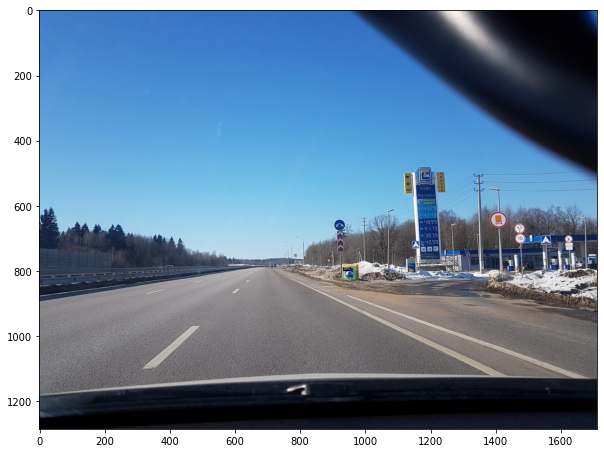

In [131]:
%matplotlib inline
i=0
while True:
    i=i+1
    d = random.sample(dataset_dicts, 1)[0]
    im = cv2.imread(d["file_name"])
    print(d["file_name"])
    im = crop_img(im)
    print("l. znakow:",len(d['annotations']))
    if len(d['annotations']) < 1:
        continue
    tic = time.time()
    outputs = predictor(im)  # format is documented at  https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    print(time.time() - tic)
    
    v = Visualizer(im[:, :, ::-1],               
        #metadata=signs_metadata, 
        scale=0.5   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize=(10,8))
    plt.imshow(out.get_image())
    print()
    print(outputs)
    break


In [111]:
w= im.shape[1]
h = im.shape[0]

In [112]:
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

In [113]:
with open('id_lbl_map.pkl', 'rb') as f:
    id_lbl_map = pickle.load(f)

In [114]:
boxes = outputs['instances'].to("cpu").pred_boxes.tensor.numpy().astype(int)
classes = outputs['instances'].to("cpu").pred_classes.numpy()
classes = np.array([id_lbl_map[clss] for clss in classes])
scores = outputs['instances'].to("cpu").scores.numpy()

In [115]:
def non_max_suppression_fast(boxes, classes, scores, overlapThresh):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []
    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")
	# initialize the list of picked indexes	
    pick = []
	# grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]
	# compute the area of the bounding boxes and sort the bounding
	# boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(scores)
	# keep looping while some indexes still remain in the indexes
	# list
    while len(idxs) > 0:
		# grab the last index in the indexes list and add the
		# index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
		# find the largest (x, y) coordinates for the start of
		# the bounding box and the smallest (x, y) coordinates
		# for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])
		# compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
		# compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]
		# delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))
	# return only the bounding boxes that were picked using the
	# integer data type
    return boxes[pick].astype("int"), classes[pick], scores[pick]

In [116]:
%matplotlib inline
def plot_box_resized(box, w, h):
    box_w = box[2] - box[0]
    box_h = box[3] - box[1]
    box_top = max(0, box[1] - box_h//4)
    box_bottom = min(h, box[3] + 3* box_h//4)
    box_l = max(0, box[0] - box_w//2)
    box_r = min(w, box[2] + box_w//2)
    print(box_r)
    crop_img = im[box_top:box_bottom, box_l:box_r]
    plt.imshow(crop_img)
    plt.show()

def plot_box(box):
    crop_img = im[box[1]:box[3], box[0]:box[2]]
    plt.imshow(crop_img)
    plt.show()

In [117]:
def extract_box(box):
    w = 640
    h=360
    box_w = box[2] - box[0]
    box_h = box[3] - box[1]
    box_top = max(0, box[1] - box_h//4)
    box_bottom = min(h, box[3] + 3* box_h//4)
    box_l = max(0, box[0] - box_w//2)
    box_r = min(w, box[2] + box_w//2)
    return im[box_top:box_bottom, box_l:box_r]

warning--curve-right--g1 0.26273128
619


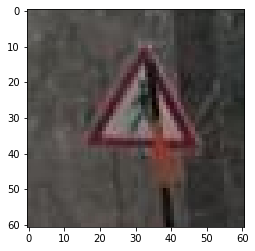

<function matplotlib.pyplot.show(close=None, block=None)>

In [118]:
for i, box in enumerate(boxes):
    print(classes[i], scores[i])
    plot_box_resized(box, im.shape[1], im.shape[0])
plt.show

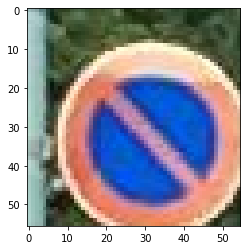

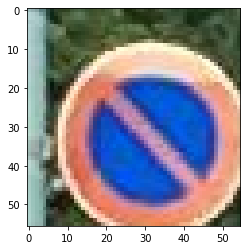

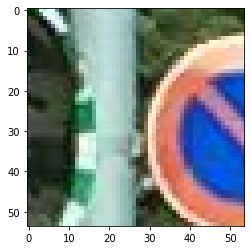

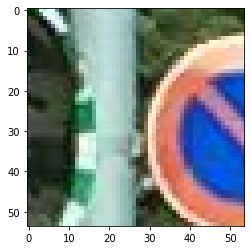

<function matplotlib.pyplot.show(close=None, block=None)>

In [108]:
for i, box in enumerate(boxes):
    plot_box(box)
plt.show

In [18]:
boxes,classes, scores = non_max_suppression_fast(boxes,classes, scores, 0.5)

ValueError: not enough values to unpack (expected 3, got 0)

In [6]:
boxes

NameError: name 'boxes' is not defined

regulatory--no-entry--g1 0.79168177


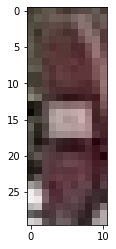

information--pedestrians-crossing--g1 0.48768684


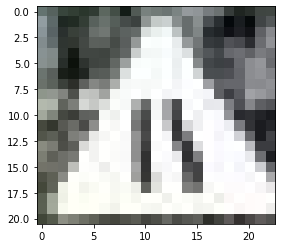

information--parking--g1 0.42323452


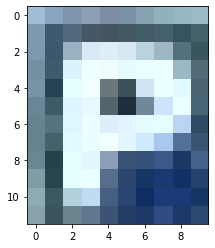

<function matplotlib.pyplot.show(close=None, block=None)>

In [29]:
for i, box in enumerate(boxes):
    print(classes[i], scores[i])
    plot_box(box)
plt.show